### ***EDA BASADO EN EL MACHINE LEARNING***

###### **Filtramos los datos**

In [2]:
# Importamos librerias 
import mysql.connector
from mysql.connector import Error
from sqlalchemy import create_engine
import pandas as pd
import os 
import env

In [3]:
# credenciales del AWS

HOST_DB = env.DB_HOST
USER_DB = env.DB_USER
PASS_DB = env.DB_PASS
NAME_DB = env.DB_NAME

In [4]:
# Funcion para conectarse a la base de datos

def BD_connection(host, user_db, user_pass, name_db):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host,
            user=user_db,
            passwd=user_pass,
            database=name_db,
            port=3306,
            connection_timeout=300
        )
        print("MYSQL DATABASE connection succesful")
    except Error as err:
        print(f"Error: '{err}'")
    return connection

In [5]:
# Nos conectamos a la base de datos 
connection = BD_connection(HOST_DB, USER_DB, PASS_DB, NAME_DB)

MYSQL DATABASE connection succesful


In [6]:
# verifiquemos la conexion realizando una consulta simple
if connection:
    cursor = connection.cursor()
    cursor.execute("SELECT DATABASE()")
    db = cursor.fetchone()
    print(f"Conectado a la base de datos: {db[0]}")

Conectado a la base de datos: UrbanTransit


In [7]:
# Funcion para obtener las tablas disponibles
def show_tables(connection):
    cursor = connection.cursor()
    cursor.execute("SHOW TABLES")
    tables = cursor.fetchall()
    for table in tables:
        print(table)

In [8]:
# Corremos la query
connection = BD_connection(HOST_DB, USER_DB, PASS_DB, NAME_DB)
show_tables(connection)

MYSQL DATABASE connection succesful
('carga_registros',)
('enriched_taxi_data1',)
('enriched_taxi_data2',)
('taxi_fhv_data',)
('taxi_fhv_data1',)
('taxi_zones',)
('temperaturas',)
('trafico',)


In [9]:
# Crear el engine de SQLAlchemy usando la conexion MySQL
def create_sqlalchemy_engine(host_name, user_bd, password_bd, name_bd):
    url = f"mysql+mysqlconnector://{user_bd}:{password_bd}@{host_name}/{name_bd}"
    return create_engine(url)

In [10]:
# Creamos el engine
engine = create_sqlalchemy_engine(HOST_DB, USER_DB, PASS_DB, NAME_DB)

In [11]:
# Consultar SQL para obtener la tabla 'users_review' y 'sites'
query_data0 = "SELECT * FROM taxi_zones;"
query_data1 = "SELECT * FROM taxi_fhv_data WHERE pickup_datetime BETWEEN '2023-01-01' AND '2024-08-31' ORDER BY id"

In [12]:
# Cargamos los datos en un Dataframe
taxi_zone = pd.read_sql(query_data0, engine)
taxi_green = pd.read_sql(query_data1, engine)

In [13]:
# Creamos un punto de reinicio
df_taxi_zone = pd.DataFrame(taxi_zone)
df_taxi_green = pd.DataFrame(taxi_green)

### Comenzamos con el EDA -- (EXPLORATORY DATA ANALYSIS) -- 

**¿En qué consiste el EDA?**
-   Consiste en investigar y comprender los datos mediante técnicas visuales y estadísticas para descubrir patrones, identificar anomalías, probar hipótesis y extraer información útil.
-  El EDA ayuda a los científicos de datos y analistas a obtener una comprensión inicial de los datos antes de aplicar modelos predictivos o análisis más avanzados.

## 1. ***Conociemiento del negocio*** 

### ***Contexto***

---------------------------------------
##### Nuestra empresa Green Route Solutions busca analizar patrones de viajes y zonas en Nueva York para identificar la mejor estrategia para implementar taxis ambientalmente amigables, considerando tanto la rentabilidad como la sostenibilidad.

**Preguntas**
>
>
> **1.Datos** <div>
> 1. ¿Qué variables están presentes en cada dataset? 
> 2. ¿Qué tipos de datos contiene cada columna?  
> 3. ¿Cuántos valores faltantes y duplicados hay por columna en cada dataset? 
> 4. ¿Hay Valores faltantes?
> 5. ¿Hay columnas anidadas? </div>
>  
> **2.Analisís Temporal** <div>
> 1. ¿Cuál es la distribución temporal de los viajes (por meses, días y horas)? </div>
> 
> **3. Analisís de Patrones de Movilidad** <div>
> 1. ¿Cuáles son las zonas con mayor número de viajes de inicio y destino 
> 2. ¿Cuáles son las distancias promedio por viaje y cómo varían según la zona o el borough? 
> 3. ¿Cuál es el tiempo promedio de los viajes y cómo se distribuyen durante el día?</div>
> 
> **4. Analísis de Financiero** <div>
> 1.  ¿Cuál es el ingreso promedio por viaje para los conductores? 
> 2. ¿Qué zonas son más rentables para los conductores y cómo se correlacionan con la cantidad de viajes?
> 3. ¿Existen diferencias significativas en los ingresos entre los diferentes boroughs? </div>
>
>
> ***Las preguntas pueden cambiar***

## 2. ***Carga de Datos*** 

In [14]:
df_taxi_green.head(4)

,id,Pickup_datetime,DropOff_datetime,PULocationID,DOLocationID,trip_miles,driver_pay,VendorID,source,trip_time
0,1,2024-06-01 00:30:14,2024-06-01 00:40:57,74,247,1.76,17.52,2,G,643
1,2,2024-06-01 00:04:36,2024-06-01 00:11:32,83,83,1.36,12.10,2,G,416
2,3,2024-06-01 00:19:43,2024-06-01 00:38:48,255,113,3.00,29.20,1,G,1145
3,4,2024-06-01 00:30:55,2024-06-01 00:43:45,66,189,2.99,18.80,2,G,770


In [15]:
df_taxi_zone.head(4)

,LocationID,Borough,Zone,the_geom
0,1,EWR,Newark Airport,MULTIPOLYGON (((-74.18445299999996 40.69499599...
1,2,Queens,Jamaica Bay,MULTIPOLYGON (((-73.82337597260663 40.63898704...
2,3,Bronx,Allerton/Pelham Gardens,MULTIPOLYGON (((-73.84792614099985 40.87134223...
3,4,Manhattan,Alphabet City,MULTIPOLYGON (((-73.97177410965318 40.72582128...


### 2.1 Análisis inicial de los datos

In [16]:
# Tamaño de los datos 
print("Tamaño de nuestros datos en df_taxi_green", df_taxi_green.shape)
print("Tamaño de nuestros datos en df_taxi_zones", df_taxi_zone.shape)

Tamaño de nuestros datos en df_taxi_green (9662238, 10)
Tamaño de nuestros datos en df_taxi_zones (261, 4)


In [17]:
# Veamos el tipo de datos que tenemos
df_taxi_green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9662238 entries, 0 to 9662237
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   Pickup_datetime   datetime64[ns]
 2   DropOff_datetime  datetime64[ns]
 3   PULocationID      int64         
 4   DOLocationID      int64         
 5   trip_miles        float64       
 6   driver_pay        float64       
 7   VendorID          object        
 8   source            object        
 9   trip_time         int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 737.2+ MB


In [18]:
df_taxi_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   LocationID  261 non-null    int64 
 1   Borough     261 non-null    object
 2   Zone        261 non-null    object
 3   the_geom    261 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.3+ KB


In [19]:
# vamos a crear funciones para saber cuantos duplicados, faltantes tenemos en los conjuntos de datos
def null(df, decimales=2):
    # cantidad de null + % 
    df_nulos = pd.DataFrame({
        "Numeros de nulos" : df.isnull().sum(),
        "Porcentaje de nulos" : (df.isnull().sum() / df.shape[0]) * 100.0 # # Calcula el porcentaje de valores faltantes en la columna
    })
    # Convierte el porcentaje a cadena y añade el símbolo de porcentaje
    df_nulos['Porcentaje de nulos'] = df_nulos['Porcentaje de nulos'].round(decimales).astype(str) + "%"
    return df_nulos


def suma_duplicados(df, decimales=2):
    # Identifica las filas duplicadas
    duplicados = df[df.duplicated()]
    
    # Inicializa diccionarios para almacenar los resultados
    num_duplicados = {}
    porcentaje_duplicados = {}
    
    for col in df.columns:
        # Cuenta el número de duplicados en la columna
        num_duplicados[col] = duplicados[col].count()
        
        # Calcula el porcentaje de duplicados en la columna
        porcentaje_duplicados[col] = (num_duplicados[col] / df.shape[0]) * 100.0
    
    # Crea un DataFrame para los resultados
    df_duplicados = pd.DataFrame({
        "Numero de Duplicados": pd.Series(num_duplicados),
        "Porcentaje de Duplicados": pd.Series(porcentaje_duplicados)
    })
    
    # Convierte el porcentaje a cadena y añade el símbolo de porcentaje
    df_duplicados["Porcentaje de Duplicados"] = df_duplicados["Porcentaje de Duplicados"].round(decimales).astype(str) + "%"
        
    return df_duplicados

In [20]:
null(df_taxi_green)

,Numeros de nulos,Porcentaje de nulos
id,0,0.0%
Pickup_datetime,0,0.0%
DropOff_datetime,0,0.0%
PULocationID,0,0.0%
DOLocationID,0,0.0%
trip_miles,0,0.0%
driver_pay,0,0.0%
VendorID,0,0.0%
source,0,0.0%
trip_time,0,0.0%


In [21]:
suma_duplicados(df_taxi_green)

,Numero de Duplicados,Porcentaje de Duplicados
id,0,0.0%
Pickup_datetime,0,0.0%
DropOff_datetime,0,0.0%
PULocationID,0,0.0%
DOLocationID,0,0.0%
trip_miles,0,0.0%
driver_pay,0,0.0%
VendorID,0,0.0%
source,0,0.0%
trip_time,0,0.0%


In [22]:
null(df_taxi_zone)

,Numeros de nulos,Porcentaje de nulos
LocationID,0,0.0%
Borough,0,0.0%
Zone,0,0.0%
the_geom,0,0.0%


In [23]:
suma_duplicados(df_taxi_zone)

,Numero de Duplicados,Porcentaje de Duplicados
LocationID,0,0.0%
Borough,0,0.0%
Zone,0,0.0%
the_geom,0,0.0%


#### **Observaciones del Dataset `df_taxis_green`**

1. **Tamaño del Dataset:**
   - El dataset contiene **9.6M de filas** y **10 columnas**.

2. **Tipos de Datos:**
   - Las columnas incluyen una variedad de tipos de datos:
     - **Numéricas:** 4 columnas.
     - **Decimales:** 2 columnas.
     - **Texto (Object):** 2 columnas.
     - **Fechas:** 2 columnas.

3. **Estructura:**
   - Las columnas de tipo fecha representan eventos clave como el inicio (`Pickup_datetime`) y el fin (`DropOff_datetime`) de los viajes.
   - Las columnas numéricas y decimales incluyen métricas relevantes como la distancia (`trip_miles`) y el pago al conductor (`driver_pay`).

4. **Duplicados y faltantes**
   - Es de mi agrado comunicar que no tenemos faltantes, ni dupulicados, ni columnas anidadas

  

In [24]:
df_taxi_green.head(4)

,id,Pickup_datetime,DropOff_datetime,PULocationID,DOLocationID,trip_miles,driver_pay,VendorID,source,trip_time
0,1,2024-06-01 00:30:14,2024-06-01 00:40:57,74,247,1.76,17.52,2,G,643
1,2,2024-06-01 00:04:36,2024-06-01 00:11:32,83,83,1.36,12.10,2,G,416
2,3,2024-06-01 00:19:43,2024-06-01 00:38:48,255,113,3.00,29.20,1,G,1145
3,4,2024-06-01 00:30:55,2024-06-01 00:43:45,66,189,2.99,18.80,2,G,770


### **Observaciones del Dataset `df_taxis_zones`**

1. **Tamaño del Dataset:**
   - El dataset contiene **261 filas** y **4 columnas**.

2. **Tipos de Datos:**
   - Las columnas incluyen los siguientes tipos de datos:
     - **Numérica:** 1 columna.
     - **Texto (Object):** 3 columnas.

3. **Estructura:**
   - La columna numérica (`LocationID`) identifica de manera única cada zona.
   - Las columnas de texto (`Borough`, `Zone`, `the_geom`) describen el distrito, la zona y la geometría respectiva de cada ubicación.


In [25]:
df_taxi_zone.head(4)

,LocationID,Borough,Zone,the_geom
0,1,EWR,Newark Airport,MULTIPOLYGON (((-74.18445299999996 40.69499599...
1,2,Queens,Jamaica Bay,MULTIPOLYGON (((-73.82337597260663 40.63898704...
2,3,Bronx,Allerton/Pelham Gardens,MULTIPOLYGON (((-73.84792614099985 40.87134223...
3,4,Manhattan,Alphabet City,MULTIPOLYGON (((-73.97177410965318 40.72582128...


## 3. ***Exploración General***

In [26]:
df_taxi_green.describe()

,id,Pickup_datetime,DropOff_datetime,PULocationID,DOLocationID,trip_miles,driver_pay,trip_time
count,9.662238e+06,9662238,9662238,9.662238e+06,9.662238e+06,9.662238e+06,9.662238e+06,9.662238e+06
mean,4.835944e+06,2024-07-14 12:26:00.922470656,2024-07-14 12:43:27.400914176,1.618151e+02,1.618318e+02,5.250012e+00,2.803903e+01,1.046478e+03
min,1.000000e+00,2024-05-24 17:04:38,2024-05-24 17:18:40,1.000000e+00,1.000000e+00,0.000000e+00,-2.265450e+03,-2.430000e+03
25%,2.417087e+06,2024-06-20 22:26:31,2024-06-20 22:42:03,1.320000e+02,1.130000e+02,1.040000e+00,1.570000e+01,4.640000e+02
50%,4.832646e+06,2024-07-14 12:06:10.500000,2024-07-14 12:21:43,1.610000e+02,1.620000e+02,1.800000e+00,2.100000e+01,7.700000e+02
75%,7.248208e+06,2024-08-05 22:36:17.750000128,2024-08-05 22:51:36.750000128,2.310000e+02,2.330000e+02,3.500000e+00,3.069000e+01,1.252000e+03
max,9.745783e+06,2024-08-30 23:59:57,2024-09-01 16:12:39,2.650000e+02,2.650000e+02,3.270250e+05,1.290340e+04,5.802170e+05
std,2.794849e+06,NaN,NaN,6.462458e+01,6.980911e+01,4.041526e+02,2.524376e+01,2.177385e+03


In [27]:
std_taxis = df_taxi_green[['trip_miles', 'trip_time', 'driver_pay']]
std_taxis.describe()

,trip_miles,trip_time,driver_pay
count,9.662238e+06,9.662238e+06,9.662238e+06
mean,5.250012e+00,1.046478e+03,2.803903e+01
std,4.041526e+02,2.177385e+03,2.524376e+01
min,0.000000e+00,-2.430000e+03,-2.265450e+03
25%,1.040000e+00,4.640000e+02,1.570000e+01
50%,1.800000e+00,7.700000e+02,2.100000e+01
75%,3.500000e+00,1.252000e+03,3.069000e+01
max,3.270250e+05,5.802170e+05,1.290340e+04


In [28]:
# cambiamos el formato para mejor visualizacion
pd.options.display.float_format = '{:,.2f}'.format

std_taxis.describe()

,trip_miles,trip_time,driver_pay
count,"9,662,238.00","9,662,238.00","9,662,238.00"
mean,5.25,"1,046.48",28.04
std,404.15,"2,177.39",25.24
min,0.00,"-2,430.00","-2,265.45"
25%,1.04,464.00,15.70
50%,1.80,770.00,21.00
75%,3.50,"1,252.00",30.69
max,"327,025.00","580,217.00","12,903.40"


#### **Vamos a ver la disperción de los datos con un histograma y un Rainplot para conocer si hay outliers**

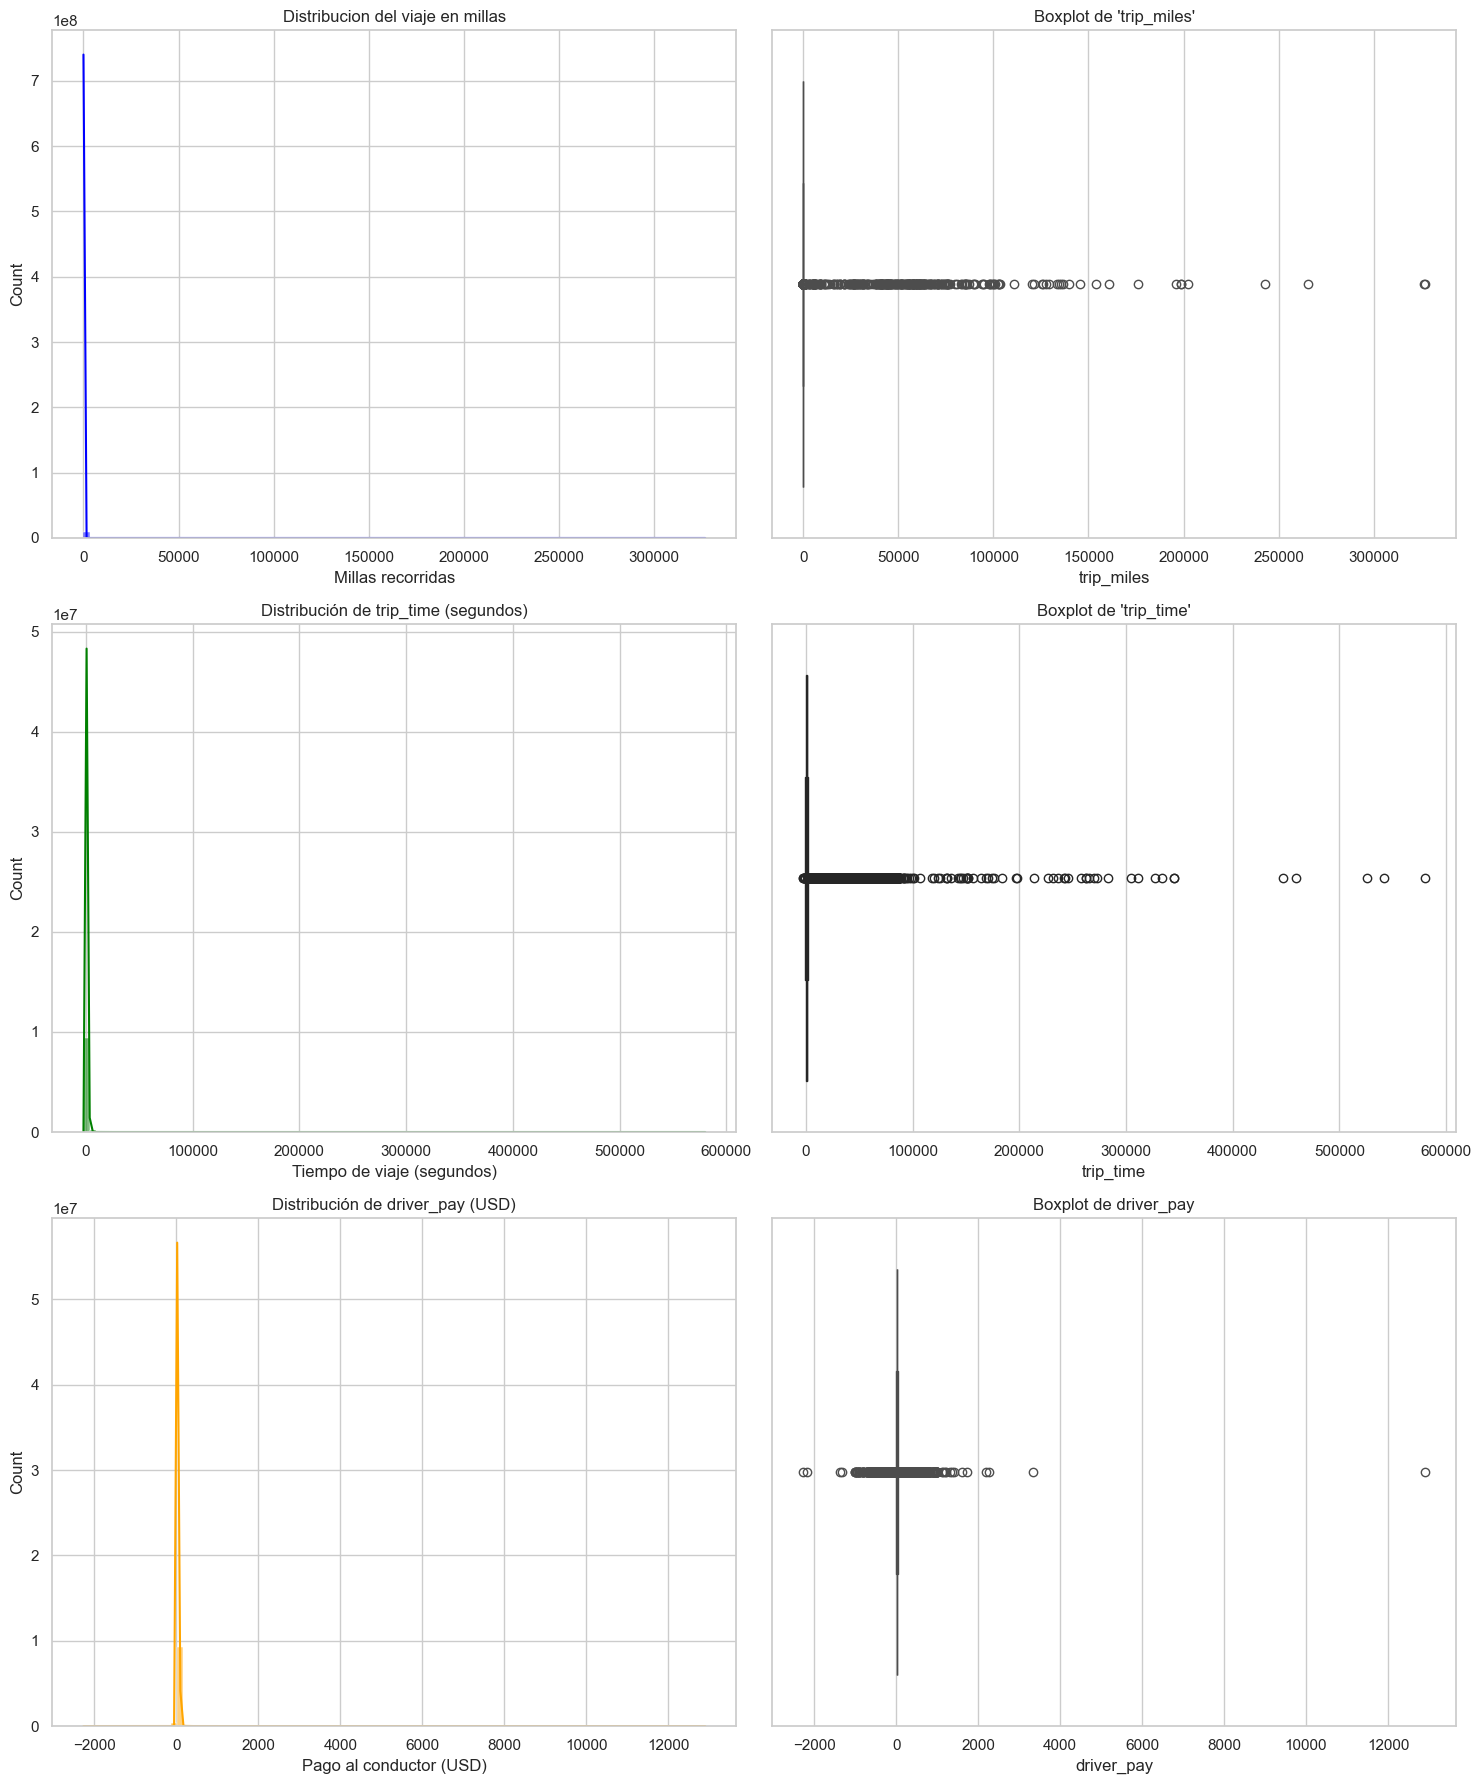

In [29]:
# Importamos librerias para crear graficos
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

sns.histplot(std_taxis['trip_miles'], bins=100, kde=True, ax=axes[0,0], color='blue')
axes[0, 0].set_title("Distribucion del viaje en millas")
axes[0, 0].set_xlabel("Millas recorridas")

sns.boxplot(x=std_taxis['trip_miles'], ax=axes[0, 1], color='blue')
axes[0, 1].set_title("Boxplot de 'trip_miles'")

# trip_time
sns.histplot(x=std_taxis['trip_time'], bins=100, kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title("Distribución de trip_time (segundos)")
axes[1, 0].set_xlabel("Tiempo de viaje (segundos)")

sns.boxplot(x=std_taxis['trip_time'], ax=axes[1, 1], color='green')
axes[1, 1].set_title("Boxplot de 'trip_time'")

# driver_pay
sns.histplot(std_taxis['driver_pay'], bins=100, kde=True, ax=axes[2, 0], color='orange')
axes[2, 0].set_title("Distribución de driver_pay (USD)")
axes[2, 0].set_xlabel("Pago al conductor (USD)")

sns.boxplot(x=std_taxis['driver_pay'], ax=axes[2, 1], color='orange')
axes[2, 1].set_title("Boxplot de driver_pay")

plt.tight_layout()
plt.show()


**Columna llamada trip_miles o Millas recorridas**

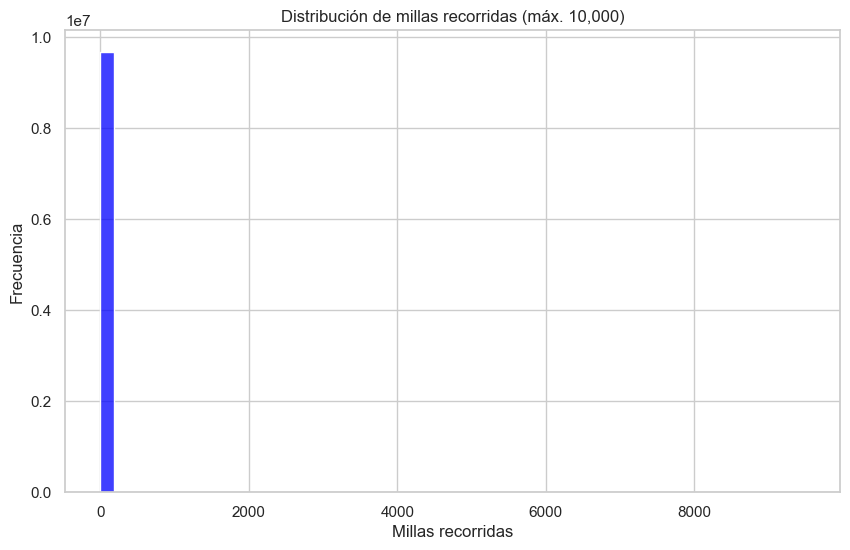

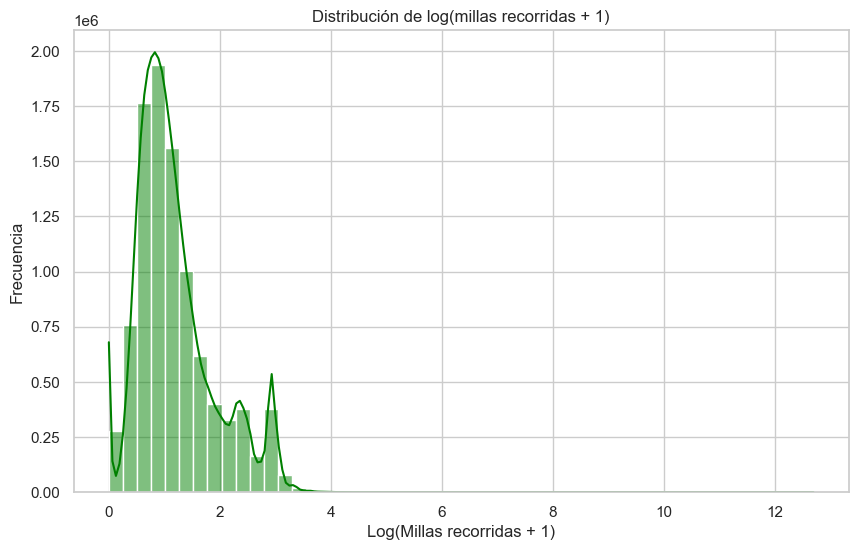

In [30]:
# Filtrar valores extremos (limitar a un rango menor)
filtered_data = std_taxis[std_taxis['trip_miles'] <= 10000]

# Histograma ajustado sin KDE
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['trip_miles'], bins=50, color='blue')
plt.title("Distribución de millas recorridas (máx. 10,000)")
plt.xlabel("Millas recorridas")
plt.ylabel("Frecuencia")
plt.show()

# Aplicar transformación logarítmica y graficar
log_trip_miles = np.log1p(std_taxis['trip_miles'])  # log(1 + x) para manejar ceros
plt.figure(figsize=(10, 6))
sns.histplot(log_trip_miles, bins=50, kde=True, color='green')
plt.title("Distribución de log(millas recorridas + 1)")
plt.xlabel("Log(Millas recorridas + 1)")
plt.ylabel("Frecuencia")
plt.show()


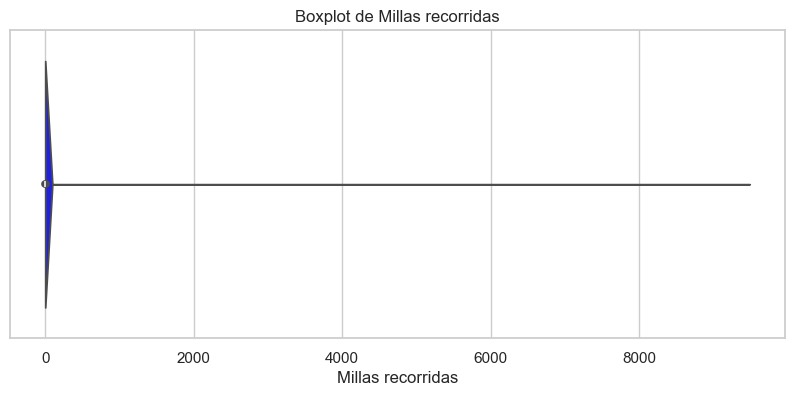

In [31]:
# Boxplot para 'trip_miles'
plt.figure(figsize=(10, 4))
sns.violinplot(x=filtered_data['trip_miles'], color='blue')
plt.title("Boxplot de Millas recorridas")
plt.xlabel("Millas recorridas")
plt.show()

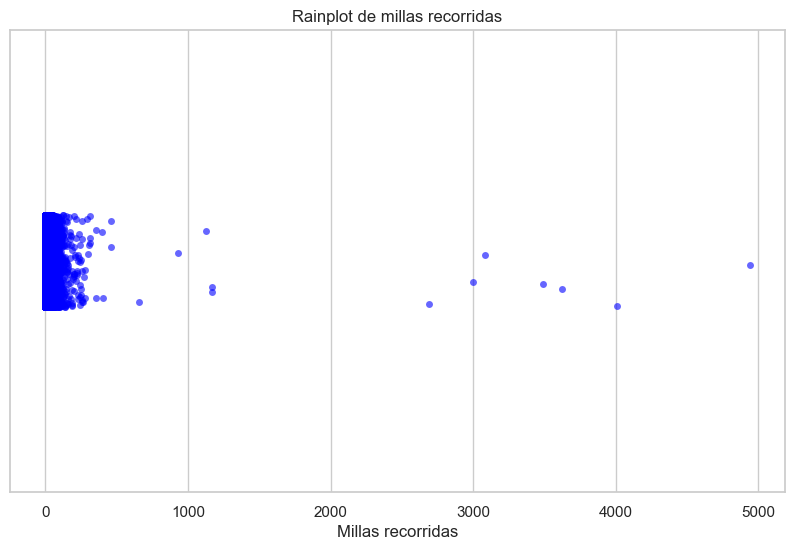

In [32]:
# Filtrar valores extremos (limitar a un rango menor)
filtered_data1 = std_taxis[std_taxis['trip_miles'] <= 5000]

# Rainplot (gráfico de lluvia) para trip_miles
plt.figure(figsize=(10, 6))
sns.stripplot(
    x=filtered_data1['trip_miles'], 
    jitter=True,  # Jitter para dispersar los puntos
    color='blue', 
    alpha=0.6  # Transparencia para puntos superpuestos
)
plt.title("Rainplot de millas recorridas")
plt.xlabel("Millas recorridas")
plt.show()


**Columna llamda Trip_time o tiempo del viaje**

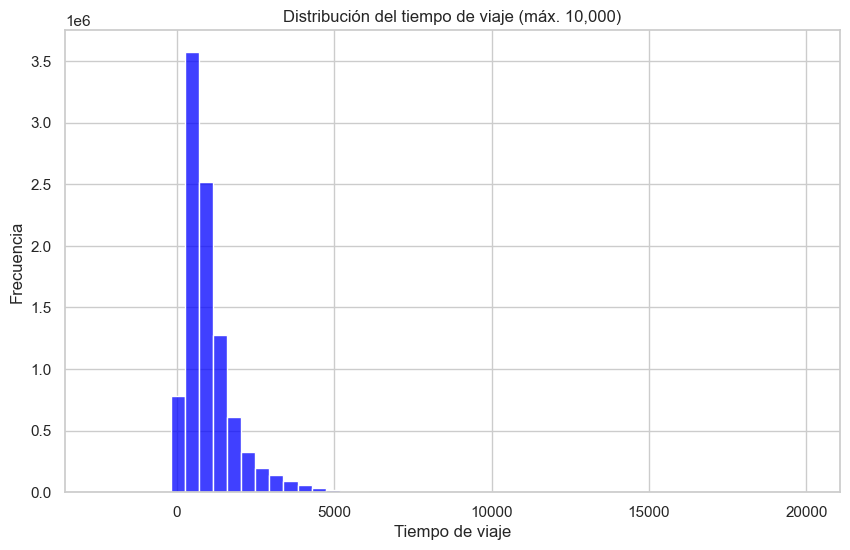

In [33]:
datos_filtrados = std_taxis[std_taxis['trip_time'] <= 20000]
# Histograma ajustado sin KDE
plt.figure(figsize=(10, 6))
sns.histplot(datos_filtrados['trip_time'], bins=50, color='blue')
plt.title("Distribución del tiempo de viaje (máx. 10,000)")
plt.xlabel("Tiempo de viaje")
plt.ylabel("Frecuencia")
plt.show()


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


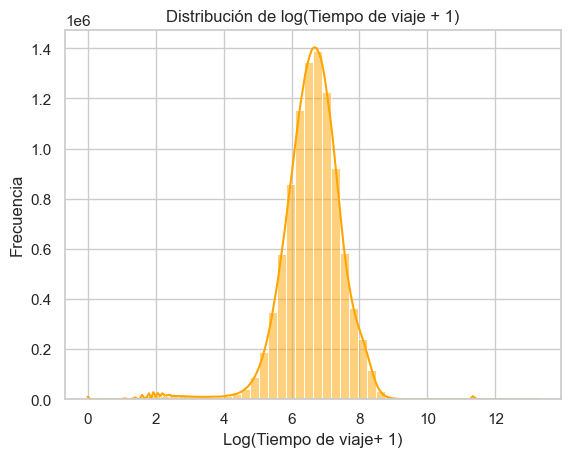

In [34]:
log_trip_time = np.log1p(std_taxis['trip_time'])
sns.histplot(log_trip_time, bins=50, kde=True, color='orange')
plt.title("Distribución de log(Tiempo de viaje + 1)")
plt.xlabel("Log(Tiempo de viaje+ 1)")
plt.ylabel("Frecuencia")
plt.show()

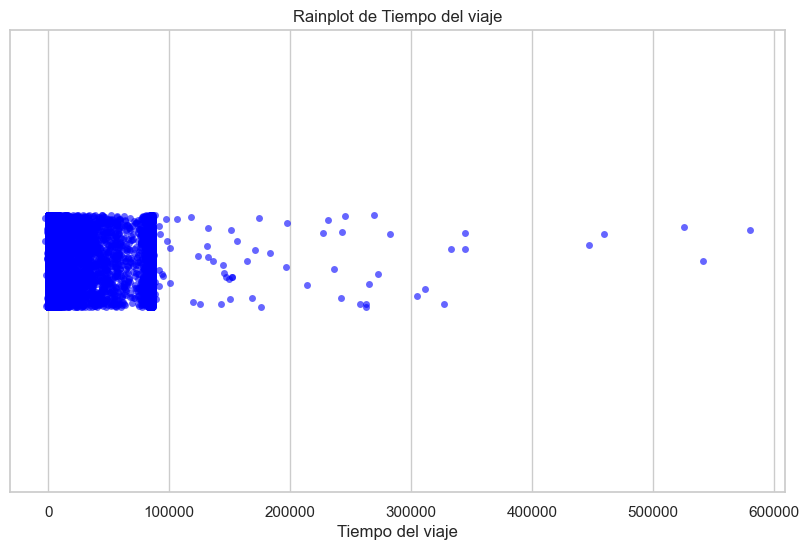

In [35]:
# Rainplot (gráfico de lluvia) para trip_time
plt.figure(figsize=(10, 6))
sns.stripplot(
    x=std_taxis['trip_time'], 
    jitter=True,  # Jitter para dispersar los puntos
    color='blue', 
    alpha=0.6  # Transparencia para puntos superpuestos
)
plt.title("Rainplot de Tiempo del viaje")
plt.xlabel("Tiempo del viaje")
plt.show()

**Columna driver_pay o Pago al conductor**

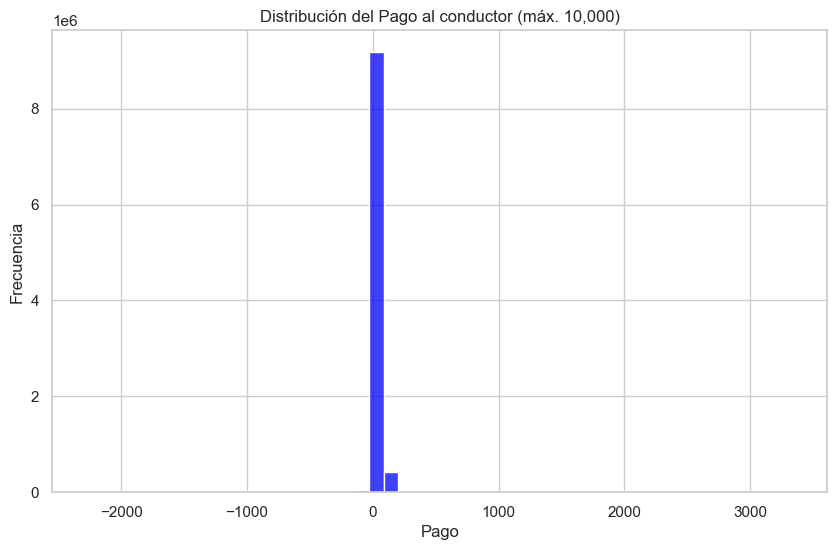

In [36]:
data_filtrada2 = std_taxis[std_taxis['driver_pay'] <= 10000]

# Histograma 
plt.figure(figsize=(10, 6))
sns.histplot(data_filtrada2['driver_pay'], bins=50, color='blue')
plt.title("Distribución del Pago al conductor (máx. 10,000)")
plt.xlabel("Pago")
plt.ylabel("Frecuencia")
plt.show()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


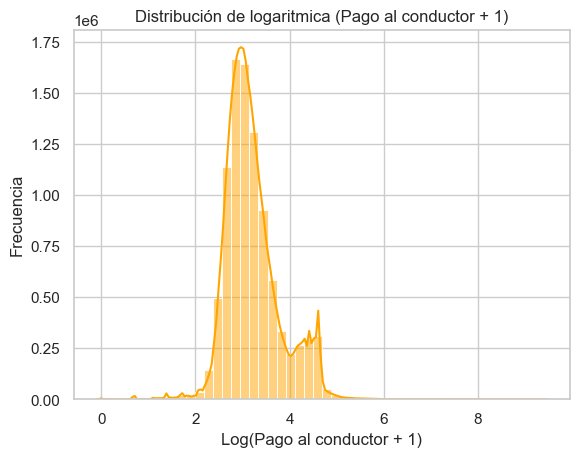

In [37]:
# Aplicamos log para entender mejor el gráfico para la columna driver_pay
log_driver_pay = np.log1p(std_taxis['driver_pay'])
sns.histplot(log_driver_pay, bins=50, kde=True, color='orange')
plt.title("Distribución de logaritmica (Pago al conductor + 1)")
plt.xlabel("Log(Pago al conductor + 1)")
plt.ylabel("Frecuencia")
plt.show()


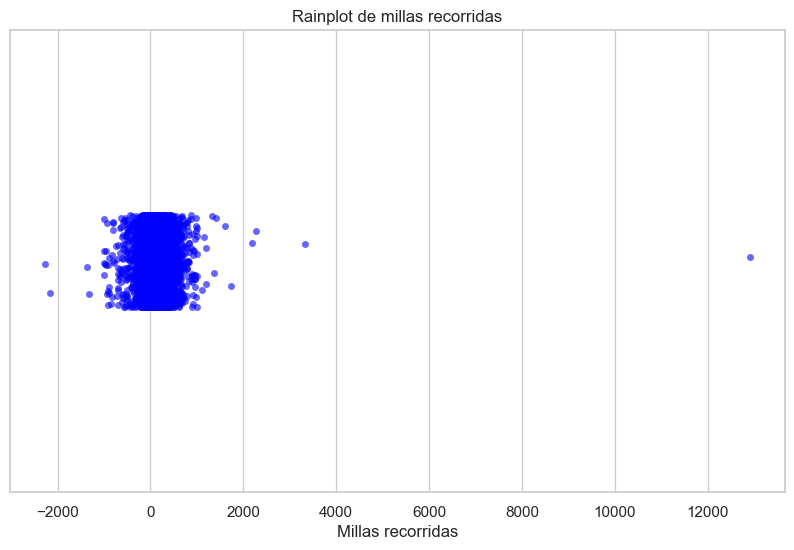

In [38]:
# filtramos los datos

# Rainplot (gráfico de lluvia) para trip_miles
plt.figure(figsize=(10, 6))
sns.stripplot(
    x=std_taxis['driver_pay'], 
    jitter=True,  # Jitter para dispersar los puntos
    color='blue', 
    alpha=0.6  # Transparencia para puntos superpuestos
)
plt.title("Rainplot de millas recorridas")
plt.xlabel("Millas recorridas")
plt.show()

### Análisis de las Columnas: `trip_miles`, `trip_time` y `driver_pay`

##### 1. `trip_miles` (Millas Recorridas)
#### Observaciones:
- La mayoría de los viajes tienen **distancias cortas**, concentrándose cerca de 0 millas.
- Hay valores extremos (outliers) que alcanzan más de **250,000 millas**, lo cual es poco probable en un viaje típico.
- El histograma original está sesgado hacia la derecha debido a estos valores extremos, dificultando la visualización de los viajes cortos.

#### Solución:
- **Transformación logarítmica**: Esta permite visualizar mejor la distribución de los viajes cortos y reduce el impacto de los valores extremos.

---

#### 2. `trip_time` (Duración del Viaje en Segundos)
#### Observaciones:
- La mayoría de los viajes son **muy cortos**, concentrándose entre **400 y 3000 segundos** (equivalente a 6–50 minutos).
- Existen valores extremadamente altos, alcanzando **80,000 segundos** (22 horas), lo que genera distorsión en el histograma original.
- El rainplot confirma la alta densidad de valores bajos, pero en el histograma sin transformación no se aprecia esta concentración debido al efecto de los outliers.

##### Solución:
- **Transformación logarítmica**: Comprime los valores extremos y resalta la concentración de viajes en el rango más frecuente.
- La distribución transformada muestra que los tiempos de viaje más comunes están entre **6 y 8 en la escala logarítmica**, lo que corresponde a 400–3000 segundos en la escala original.

---

#### 3. `driver_pay` (Pago al Conductor en USD)
#### Observaciones:
- La mayoría de los pagos están concentrados cerca de **0 a 50 USD**, indicando que la mayoría de los viajes generan ingresos bajos para los conductores.
- Existen valores extremos que alcanzan hasta **4,000 USD**, lo cual es inusual y puede ser producto de datos anómalos o errores.
- El histograma original sufre el mismo problema de sesgo hacia la derecha, lo que dificulta interpretar la distribución de los valores pequeños.

##### Solución:
- **Transformación logarítmica**: Permite visualizar la mayor concentración de datos entre **1.5 y 3.5 en la escala logarítmica**, que corresponde aproximadamente a **$5 a $30 USD** en la escala original.
- Esto resalta que la mayoría de los viajes generan ingresos modestos para los conductores.

---

#### Conclusión General
- Las columnas `trip_miles`, `trip_time` y `driver_pay` presentan distribuciones altamente sesgadas hacia la derecha debido a valores extremos (outliers).
- **La transformación logarítmica es clave** para interpretar correctamente las distribuciones y realizar análisis más precisos.
- La mayoría de los viajes son cortos en tiempo y distancia, generando ingresos bajos para los conductores.



#### ***Ahora vemos la correlación de las columnas***

In [39]:
# Primero creamos la correlación, luego lo gráficamos
correlation_matrix = std_taxis.corr()
print(correlation_matrix)

            trip_miles  trip_time  driver_pay
trip_miles        1.00       0.00        0.01
trip_time         0.00       1.00        0.27
driver_pay        0.01       0.27        1.00


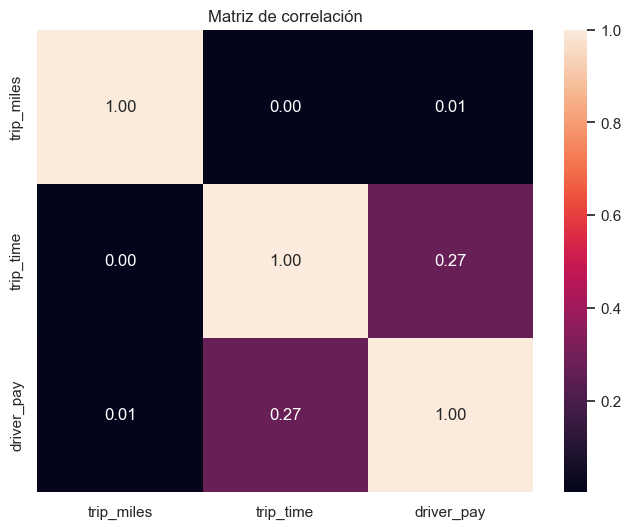

In [40]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

#### ***La matriz sin el logaritmo <-***
 - Porque la correlación es baja?
 - Cuando vemos que las correlaciones son débiles (especialmente entre trip_miles y las otras variables), eso puede deberse a la presencia de outliers, valores atípicos extremos que distorsionan la relación.*** 

#### ***La matriz con el logaritmo ->***

In [41]:
# Aplicar logaritmo a las variables relevantes

log_std_taxis = std_taxis

log_std_taxis['log_trip_miles'] = np.log(log_std_taxis['trip_miles'] + 1)
log_std_taxis['log_trip_time'] = np.log(log_std_taxis['trip_time'] + 1)
log_std_taxis['log_driver_pay'] = np.log(log_std_taxis['driver_pay'] + 1)

# Revisar correlaciones con los datos transformados
correlation_matrix = log_std_taxis[['log_trip_miles', 'log_trip_time', 'log_driver_pay']].corr()
print(correlation_matrix)


C:\Users\DELL\AppData\Local\Temp\ipykernel_1100\2940912452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_std_taxis['log_trip_miles'] = np.log(log_std_taxis['trip_miles'] + 1)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_1100\2940912452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

                log_trip_miles  log_trip_time  log_driver_pay
log_trip_miles            1.00           0.76            0.85
log_trip_time             0.76           1.00            0.69
log_driver_pay            0.85           0.69            1.00


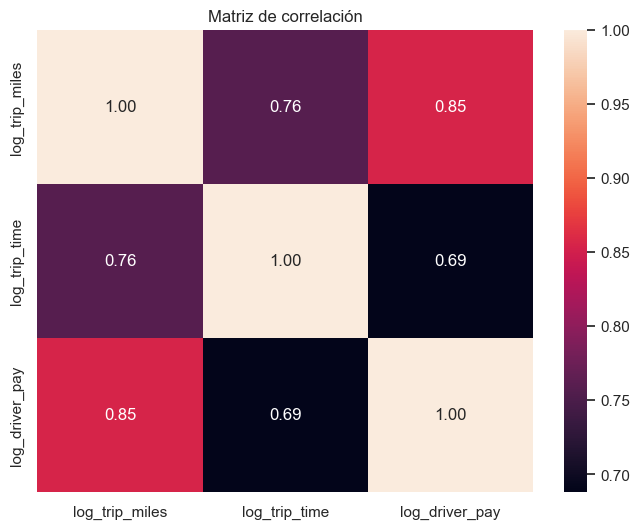

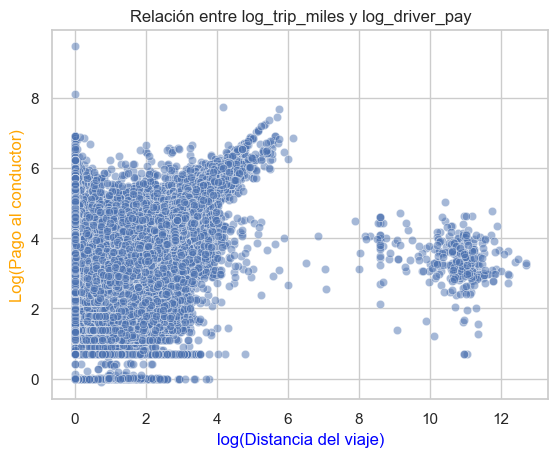

In [42]:
# Graficamos un headmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

# Scatter plot ejemplo
sns.scatterplot(x='log_trip_miles', y='log_driver_pay', data=log_std_taxis, alpha=0.5)
plt.xlabel("log(Distancia del viaje)", color='blue')
plt.ylabel("Log(Pago al conductor)", color = 'orange')
plt.title('Relación entre log_trip_miles y log_driver_pay')
plt.show()

### Análisis de Correlación: Datos Originales vs Transformación Logarítmica

#### **1. Correlación Original**
| `trip_miles` | `trip_time` | `driver_pay` |
|--------------|-------------|--------------|
| **1.00**     | **0.00**    | **0.01**     |
| **0.00**     | **1.00**    | **0.27**     |
| **0.01**     | **0.27**    | **1.00**     |

#### **Interpretación inicial:**
- Los valores muestran **muy poca correlación** entre `trip_miles`, `trip_time` y `driver_pay`.
- Esto contradice la intuición: los datos deberían ser **directamente proporcionales** porque:
  - **Viajes más largos deberían implicar más tiempo y mayor pago.**
- **Problema identificado:**
  - **Outliers** distorsionaron los valores, ocultando las relaciones esperadas entre las variables.

---

#### **2. Aplicación de la Transformación Logarítmica**
Se aplicó la siguiente fórmula a cada columna:
\[
\text{log(column) = log(column + 1)}
\]
Esto comprime los valores extremos y atenúa el impacto de los outliers.

---

#### **3. Correlación con Datos Transformados**
| `log_trip_miles` | `log_trip_time` | `log_driver_pay` |
|------------------|----------------|-------------------|
| **1.00**         | **0.76**       | **0.85**          |
| **0.76**         | **1.00**       | **0.69**          |
| **0.85**         | **0.69**       | **1.00**          |

#### **Interpretación después del logaritmo:**
1. **Relación entre `log_trip_miles` y `log_trip_time` (0.76):**
   - Existe una **fuerte correlación positiva**: **viajes más largos** tienden a durar más tiempo.
2. **Relación entre `log_trip_miles` y `log_driver_pay` (0.85):**
   - Relación muy fuerte: **más millas recorridas**, mayor es el pago al conductor.
3. **Relación entre `log_trip_time` y `log_driver_pay` (0.69):**
   - Aunque no tan alta como las anteriores, refleja que **viajes más largos en tiempo** suelen generar **mayores pagos**.

---

#### **4. Conclusiones**
1. Los **outliers** en los datos originales ocultaban relaciones importantes.
2. **La transformación logarítmica** permite:
   - Reducir el impacto de los valores extremos.
   - Hacer que las correlaciones reflejen el comportamiento real esperado.
3. Ahora los datos son mucho más interpretables y pueden usarse para análisis más precisos.

#### ***Analizamos las columnas de fecha***

In [43]:
df_taxi_green.head(4)

,id,Pickup_datetime,DropOff_datetime,PULocationID,DOLocationID,trip_miles,driver_pay,VendorID,source,trip_time
0,1,2024-06-01 00:30:14,2024-06-01 00:40:57,74,247,1.76,17.52,2,G,643
1,2,2024-06-01 00:04:36,2024-06-01 00:11:32,83,83,1.36,12.10,2,G,416
2,3,2024-06-01 00:19:43,2024-06-01 00:38:48,255,113,3.00,29.20,1,G,1145
3,4,2024-06-01 00:30:55,2024-06-01 00:43:45,66,189,2.99,18.80,2,G,770


In [44]:
df_taxi_green['month'] = df_taxi_green['Pickup_datetime'].dt.month
df_taxi_green['month_name'] = df_taxi_green['Pickup_datetime'].dt.month_name()
df_taxi_green['day_of_week'] = df_taxi_green['Pickup_datetime'].dt.day_name()
df_taxi_green['year'] = df_taxi_green['Pickup_datetime'].dt.year
df_taxi_green['hour'] = df_taxi_green['Pickup_datetime'].dt.hour


df_taxi_green.head(4)

,id,Pickup_datetime,DropOff_datetime,PULocationID,DOLocationID,trip_miles,driver_pay,VendorID,source,trip_time,month,month_name,day_of_week,year,hour
0,1,2024-06-01 00:30:14,2024-06-01 00:40:57,74,247,1.76,17.52,2,G,643,6,June,Saturday,2024,0
1,2,2024-06-01 00:04:36,2024-06-01 00:11:32,83,83,1.36,12.10,2,G,416,6,June,Saturday,2024,0
2,3,2024-06-01 00:19:43,2024-06-01 00:38:48,255,113,3.00,29.20,1,G,1145,6,June,Saturday,2024,0
3,4,2024-06-01 00:30:55,2024-06-01 00:43:45,66,189,2.99,18.80,2,G,770,6,June,Saturday,2024,0


C:\Users\DELL\AppData\Local\Temp\ipykernel_1100\1425311524.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=df_taxi_green, palette='viridis')


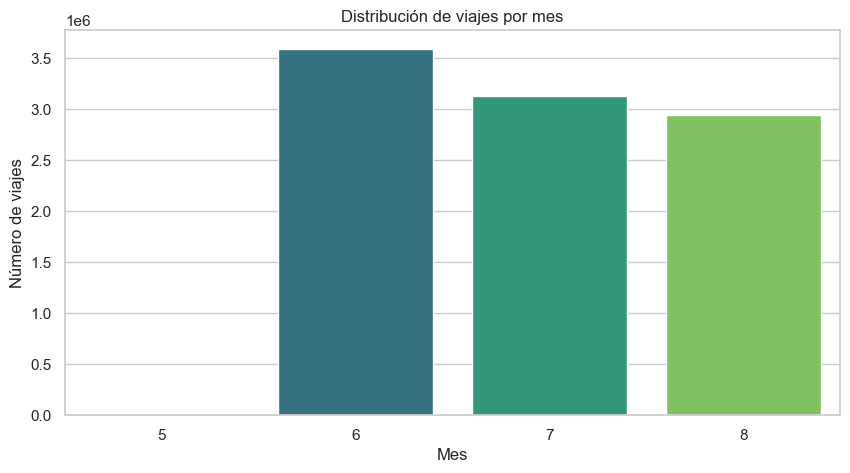

C:\Users\DELL\AppData\Local\Temp\ipykernel_1100\1425311524.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=df_taxi_green, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='muted')


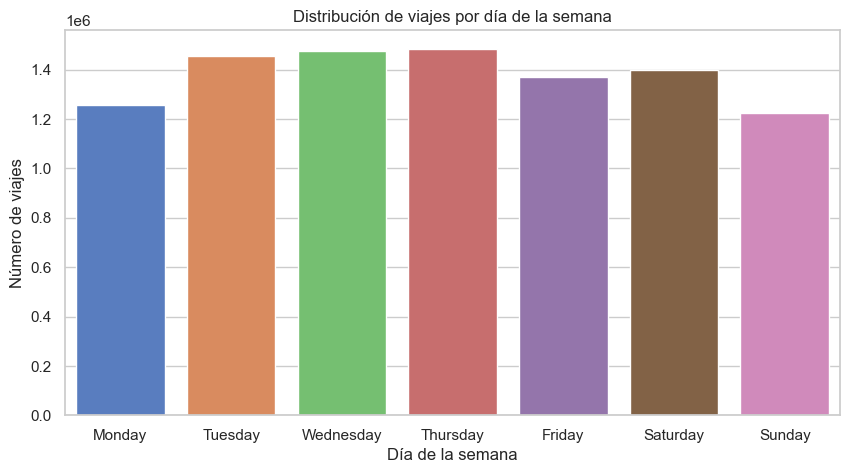

C:\Users\DELL\AppData\Local\Temp\ipykernel_1100\1425311524.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df_taxi_green, palette='coolwarm')


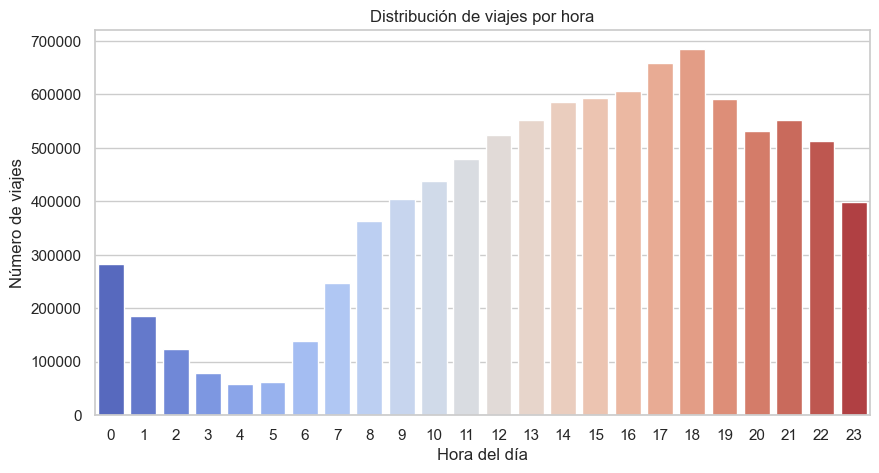

In [45]:
# Distribución por Meses
plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=df_taxi_green, palette='viridis')
plt.title("Distribución de viajes por mes")
plt.xlabel("Mes")
plt.ylabel("Número de viajes")
plt.show()

# Distribución por Días de la Semana
plt.figure(figsize=(10, 5))
sns.countplot(x='day_of_week', data=df_taxi_green, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='muted')
plt.title("Distribución de viajes por día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Número de viajes")
plt.show()

# Distribución por Horas
plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df_taxi_green, palette='coolwarm')
plt.title("Distribución de viajes por hora")
plt.xlabel("Hora del día")
plt.ylabel("Número de viajes")
plt.show()

***Ahora veamos un mapa***

In [46]:
df_taxi_zone.head(2)

,LocationID,Borough,Zone,the_geom
0,1,EWR,Newark Airport,MULTIPOLYGON (((-74.18445299999996 40.69499599...
1,2,Queens,Jamaica Bay,MULTIPOLYGON (((-73.82337597260663 40.63898704...


In [48]:
# Importamos la libreria para visualizar el mapa
import folium
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon

# Convertir la columna 'the_geom' de WKT a objetos geométricos
df_taxi_zone['geometry'] = df_taxi_zone['the_geom'].apply(wkt.loads)

# Crear un mapa centrado en Nueva York
ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Lista de colores para las zonas
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

# Iterar por todas las zonas y añadir cada multipolygon al mapa con un color diferente
for idx, row in df_taxi_zone.iterrows():
    geometry = row['geometry']
    color = colors[idx % len(colors)]  # Asignar un color de la lista de colores
    if isinstance(geometry, MultiPolygon):
        for polygon in geometry.geoms:
            coords = [(point[1], point[0]) for point in polygon.exterior.coords]
            folium.Polygon(locations=coords, color=color, fill=True, fill_opacity=0.4).add_to(ny_map)
    elif isinstance(geometry, Polygon):
        coords = [(point[1], point[0]) for point in geometry.exterior.coords]
        folium.Polygon(locations=coords, color=color, fill=True, fill_opacity=0.4).add_to(ny_map)

# Guardar el mapa en un archivo HTML
ny_map.save('nyc_all_zones_map.html')
ny_map

GEOSException: ParseException: Expected word but encountered end of stream